In [1]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm


In [2]:
dest = pd.read_csv('destinations.csv',nrows=50000)
dest.shape

(50000, 150)

In [4]:
df = pd.read_csv('train.csv',nrows=100000)
df.shape

(100000, 24)

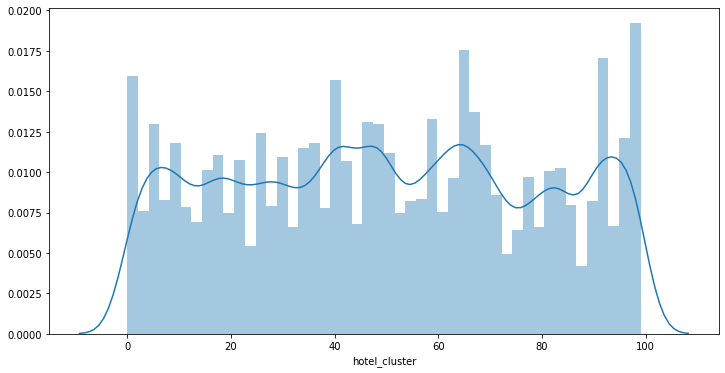

In [5]:
plt.figure(figsize=(12, 6))
sns.distplot(df['hotel_cluster'])

In [6]:
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass
def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass
    
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [7]:
df['date_time_year'] = pd.Series(df.date_time, index = df.index)
df['date_time_month'] = pd.Series(df.date_time, index = df.index)
from datetime import datetime
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))
del df['date_time']

In [8]:
df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)
# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))
# remove the srch_ci column
del df['srch_ci']

In [9]:
df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)
# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))
# remove the srch_co column
del df['srch_co']

In [10]:
df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.030064
is_booking                  -0.025380
user_location_country       -0.025170
hotel_country               -0.021170
site_name                   -0.019154
hotel_continent             -0.008441
srch_destination_id         -0.007258
user_location_city          -0.006580
channel                     -0.005956
srch_rm_cnt                 -0.005801
is_mobile                   -0.002803
srch_co_month               -0.000413
date_time_year               0.000696
cnt                          0.000914
date_time_month              0.001208
user_id                      0.001396
srch_ci_month                0.001682
posa_continent               0.002204
srch_children_cnt            0.005469
srch_adults_cnt              0.007322
user_location_region         0.008037
srch_ci_year                 0.010879
orig_destination_distance    0.011362
srch_co_year                 0.012014
hotel_market                 0.036107
is_package                   0.051955
hotel_cluste

In [11]:
pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
8                   50            416          32               1      2
                                               60               0      1
                                               77               1      2
11                  50            824          94               1      2
14                  27            1434         20               1      3

In [12]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,32,0.5,0.4,0.469388
1,8,50,416,60,0.0,0.2,0.061224
2,8,50,416,77,0.5,0.4,0.469388
3,11,50,824,94,1.0,1.0,1.000000
4,14,27,1434,20,1.0,0.6,0.812500


In [13]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,102,1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
df.fillna(0, inplace=True)
df.shape

(100000, 276)

In [17]:
df = df.loc[df['is_booking'] == 1]

In [21]:
# X = df.drop(['is_booking'], axis=1)
# y = df.hotel_cluster

df.hotel_cluster

1         1
20        2
27       58
72       36
79       95
         ..
99814    15
99899     7
99903    93
99914    72
99931    95
Name: hotel_cluster, Length: 8270, dtype: int64

In [53]:
X_test_hotel = X[3:4]['hotel_cluster']
X_test_user = X[3:4]['user_id']
X = X.tail(62)
# X_test
print(X_test_hotel)
print(X_test_user)

72    36
Name: hotel_cluster, dtype: int64
72    1048
Name: user_id, dtype: int64


In [54]:
y_test = y.head(1)
y = y.tail(62)

In [55]:
import pickle
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X,y)
filename = 'lor_model.sav'
pickle.dump(clf,open(filename,'wb'))
print("Model Saved")

C:\Users\Personal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Personal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model Saved


In [22]:
import pickle
from sklearn import svm
clf = svm.SVC()
clf.fit(X,y)
filename = 'svm_hotel.sav'
pickle.dump(clf,open(filename,'wb'))

C:\Users\Personal\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [57]:
test = X[3:4]
test

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,90,91,92,93,94,95,96,97,98,99
99248,24,2,3,64,3169,0.0,388000,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046847,0.0,0.005405


In [58]:
# X.head(1).shape
y_pred = clf.predict(test)

In [59]:
y_pred

array([85], dtype=int64)

In [60]:
y_test = np.array(y[3:4])

In [61]:
y_test

array([85], dtype=int64)